Contributions from:

* DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493

* JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503

* hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

In [1]:
# warnings management
import warnings;
#warnings.simplefilter('default')
#warnings.simplefilter('once')
#warnings.filterwarnings('ignore')

In [2]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import xgboost
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module wi

## Load data

In [3]:
AIR_RESERVE = 'air_reserve'
AIR_STORE_INFO = 'air_store_info'
AIR_VISIT_DATA = 'air_visit_data'
DATE_INFO = 'date_info'
HPG_RESERVE = 'hpg_reserve'
HPG_STORE_INFO = 'hpg_store_info'
STORE_ID_RELATION = 'store_id_relation'
SAMPLE_SUBMISSION = 'sample_submission'

data = {
    AIR_RESERVE:        pd.read_csv('../data/raw/air_reserve.csv',
                                    parse_dates=['visit_datetime', 'reserve_datetime']),
    AIR_STORE_INFO:     pd.read_csv('../data/raw/air_store_info.csv'),
    AIR_VISIT_DATA:     pd.read_csv('../data/raw/air_visit_data.csv',
                                    parse_dates=['visit_date']),
    DATE_INFO:          pd.read_csv('../data/raw/date_info.csv')
                                    .rename(columns={'calendar_date':'visit_date'}),
    HPG_RESERVE:        pd.read_csv('../data/raw/hpg_reserve.csv',
                                    parse_dates=['visit_datetime', 'reserve_datetime']),
    HPG_STORE_INFO:     pd.read_csv('../data/raw/hpg_store_info.csv'),
    STORE_ID_RELATION:  pd.read_csv('../data/raw/store_id_relation.csv'),
    SAMPLE_SUBMISSION:  pd.read_csv('../data/raw/sample_submission.csv')
}

## Feature engineering

In [4]:
data[HPG_RESERVE] = pd.merge(data[HPG_RESERVE], data[STORE_ID_RELATION], how='inner', on=['hpg_store_id'])

for df in [AIR_RESERVE,HPG_RESERVE]:
    # Get rid of time portion as is not that important in our case
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date    
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = \
        data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
        
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False) \
        [['reserve_datetime_diff', 'reserve_visitors']].sum() \
            .rename(columns={'visit_datetime':'visit_date', 
                             'reserve_datetime_diff': 'rs1', 
                             'reserve_visitors':'rv1'})            
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False) \
        [['reserve_datetime_diff', 'reserve_visitors']].mean() \
            .rename(columns={'visit_datetime':'visit_date', 
                             'reserve_datetime_diff': 'rs2', 
                             'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [5]:
data[AIR_VISIT_DATA]['dow'] = data[AIR_VISIT_DATA]['visit_date'].dt.dayofweek
data[AIR_VISIT_DATA]['year'] = data[AIR_VISIT_DATA]['visit_date'].dt.year
data[AIR_VISIT_DATA]['month'] = data[AIR_VISIT_DATA]['visit_date'].dt.month
data[AIR_VISIT_DATA]['visit_date'] = data[AIR_VISIT_DATA]['visit_date'].dt.date

In [6]:
data[SAMPLE_SUBMISSION]['visit_date'] = data[SAMPLE_SUBMISSION]['id'].map(lambda x: str(x).split('_')[2])
data[SAMPLE_SUBMISSION]['air_store_id'] = data[SAMPLE_SUBMISSION]['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data[SAMPLE_SUBMISSION]['visit_date'] = pd.to_datetime(data[SAMPLE_SUBMISSION]['visit_date'])

data[SAMPLE_SUBMISSION]['dow'] = data[SAMPLE_SUBMISSION]['visit_date'].dt.dayofweek
data[SAMPLE_SUBMISSION]['year'] = data[SAMPLE_SUBMISSION]['visit_date'].dt.year
data[SAMPLE_SUBMISSION]['month'] = data[SAMPLE_SUBMISSION]['visit_date'].dt.month
data[SAMPLE_SUBMISSION]['visit_date'] = data[SAMPLE_SUBMISSION]['visit_date'].dt.date

In [7]:
unique_stores = data[SAMPLE_SUBMISSION]['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], 
                      axis=0, ignore_index=True
                  ).reset_index(drop=True)

In [8]:
#sure it can be compressed...
tmp = data[AIR_VISIT_DATA].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data[AIR_VISIT_DATA].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data[AIR_VISIT_DATA].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data[AIR_VISIT_DATA].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data[AIR_VISIT_DATA].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data[AIR_STORE_INFO], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data[DATE_INFO]['visit_date'] = pd.to_datetime(data[DATE_INFO]['visit_date'])
data[DATE_INFO]['day_of_week'] = lbl.fit_transform(data[DATE_INFO]['day_of_week'])
data[DATE_INFO]['visit_date'] = data[DATE_INFO]['visit_date'].dt.date

## Prepare Train and Test datasets

In [9]:
train = pd.merge(data[AIR_VISIT_DATA],    data[DATE_INFO], how='left', on=['visit_date']) 
test  = pd.merge(data[SAMPLE_SUBMISSION], data[DATE_INFO], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test  = pd.merge(test,  stores, how='left', on=['air_store_id','dow'])

for df in [AIR_RESERVE,HPG_RESERVE]:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test  = pd.merge(test,  data[df], how='left', on=['air_store_id','visit_date'])

train['store_id_relation'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

features = [c for c in train if c not in ['store_id_relation', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

X_train = train[features]
y_train = np.log1p(train['visitors'].values)

X_test = test[features]

#### Train and Test sets visualized

In [10]:
train.shape

(252108, 54)

In [11]:
train.columns

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
       'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'store_id_relation',
       'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean',
       'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat',
       'air_store_id2'],
      dtype='object')

In [12]:
test.shape

(32019, 54)

In [13]:
test.columns

Index(['id', 'visitors', 'visit_date', 'air_store_id', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
       'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum',
       'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int',
       'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2'],
      dtype='object')

## Model Fitting

#### Model Evaluation Metric

In [14]:
# RMSLE measures the ratio between actual and predicted.
# It can be used when we don’t want to penalize huge differences when both the values are huge numbers.
# Also, this can be used when we want to penalize under estimates MORE than over estimates.
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

#### Model Training Evaluation

In [15]:
def train_and_predict(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    return y_pred, RMSLE(y_train, y_pred)

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(18,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print("Train sizes:", train_sizes)
    #print("Train scores:", train_scores)
    #print("Test scores:", print(test_scores))
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show();

In [17]:
def plot_error_evaluation_1(train, y_train, y_pred):
    df_error_eval = pd.DataFrame()
    df_error_eval['visit_date']         = train['visit_date']
    df_error_eval['visitors_log_train'] = y_train
    df_error_eval['visitors_log_pred']  = y_pred
    df_error_eval['visitors_train']     = np.expm1(y_train)
    df_error_eval['visitors_pred']      = np.expm1(y_pred)
    df_error_eval['visitors_pred_train_diff'] = df_error_eval['visitors_pred'] - df_error_eval['visitors_train']
       
    # plot
    fig = plt.figure(figsize=(18,6))
    plt.plot(df_error_eval['visitors_pred_train_diff']);
    plt.axhline(y=0, color='r', linewidth=0.5, linestyle='dashed');
    
    plt.title("Error (predicted visitors - actual visitors) for all training examples")
    plt.xlabel("Training examples")
    plt.ylabel("Error value");
    plt.show();

    
def plot_error_evaluation_2(train, y_train, y_pred):
    df_error_eval = pd.DataFrame()
    df_error_eval['visit_date']         = train['visit_date']
    df_error_eval['visitors_log_train'] = y_train
    df_error_eval['visitors_log_pred']  = y_pred
    df_error_eval['visitors_train']     = np.expm1(y_train)
    df_error_eval['visitors_pred']      = np.expm1(y_pred)
    df_error_eval['visitors_pred_train_diff'] = df_error_eval['visitors_pred'] - df_error_eval['visitors_train']
       
    df_error_eval_sorted = df_error_eval.sort_values(['visit_date'])
    df_error_eval_sorted.set_index('visit_date', inplace=True)
    
    # plot
    fig = plt.figure(figsize=(18,6))
    plt.plot(df_error_eval_sorted['visitors_pred_train_diff'])
    plt.axhline(y=0, color='r', linewidth=0.5, linestyle='dashed');

    plt.title("Error (predicted visitors - actual visitors) for all training examples over time")
    plt.xlabel("Prediction visit date")
    plt.ylabel("Error value");
    plt.show();
    
    
def plot_error_evaluation_3(train, y_train, y_pred):
    df_error_eval = pd.DataFrame()
    df_error_eval['visit_date']         = train['visit_date']
    df_error_eval['visitors_log_train'] = y_train
    df_error_eval['visitors_log_pred']  = y_pred
    df_error_eval['visitors_train']     = np.expm1(y_train)
    df_error_eval['visitors_pred']      = np.expm1(y_pred)
    df_error_eval['visitors_pred_train_diff'] = df_error_eval['visitors_pred'] - df_error_eval['visitors_train']
       
    df_error_eval_sorted = df_error_eval.sort_values(['visit_date'])
    df_error_eval_sorted.set_index('visit_date', inplace=True)
    
    df_error_eval_narrowed = df_error_eval_sorted[df_error_eval_sorted['visitors_pred_train_diff'] > -70]
    df_error_eval_narrowed_mean = df_error_eval_narrowed['visitors_pred_train_diff'].mean()

    # plot
    fig = plt.figure(figsize=(18,6))
    plt.hist(df_error_eval_narrowed['visitors_pred_train_diff'], bins=200)
    plt.axvline(x=df_error_eval_narrowed_mean, color='b', linewidth=0.5, linestyle='dashed');

    plt.title("Histogram of error distribution (only errors > -70) \n mean={0:0.2f}" \
                .format(df_error_eval_narrowed_mean))
    plt.xlabel("Error value")
    plt.ylabel("Count");
    plt.show();

### Models

In [18]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, 
                                            random_state=3, 
                                            n_estimators=5, # best result: 200 
                                            subsample=0.8, 
                                            max_depth =10,
                                            verbose=0)

model2 = neighbors.KNeighborsRegressor(n_jobs=-1, 
                                       n_neighbors=4)

model3 = XGBRegressor(max_depth =12, 
                      learning_rate=0.2, 
                      n_estimators=20, # originally 280, 
                      subsample=0.8, 
                      colsample_bytree=0.8, 
                      seed=3)

models = [ 
    ("GradientBoostingRegressor", model1),
    ("KNeighborsRegressor", model2),
    ("XGBRegressor", model3)
]


Model name:  GradientBoostingRegressor
Details: 
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, presort='auto', random_state=3, subsample=0.8,
             verbose=0, warm_start=False)

RMSLE GradientBoostingRegressor: 0.54


/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:93: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:93: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:93: FutureWarning: np.average currently does not preserve subclasses, but will

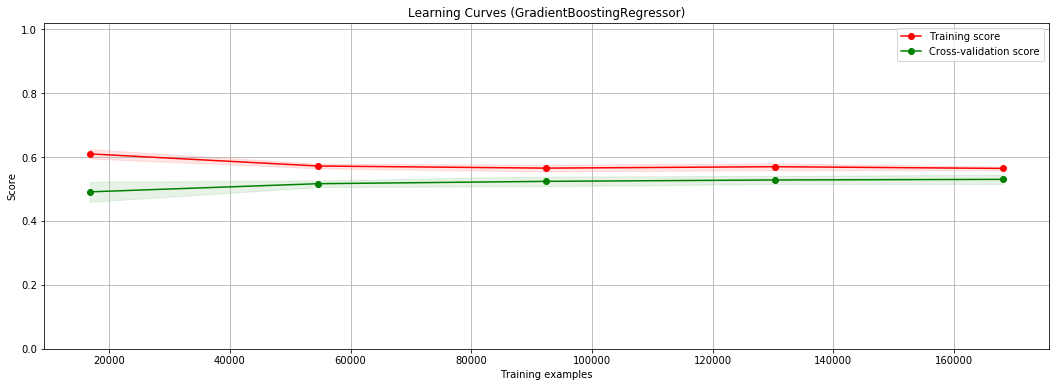

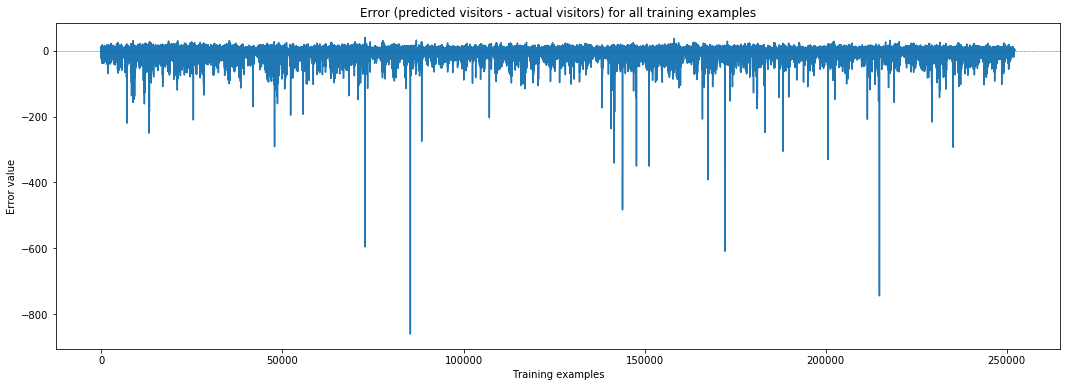

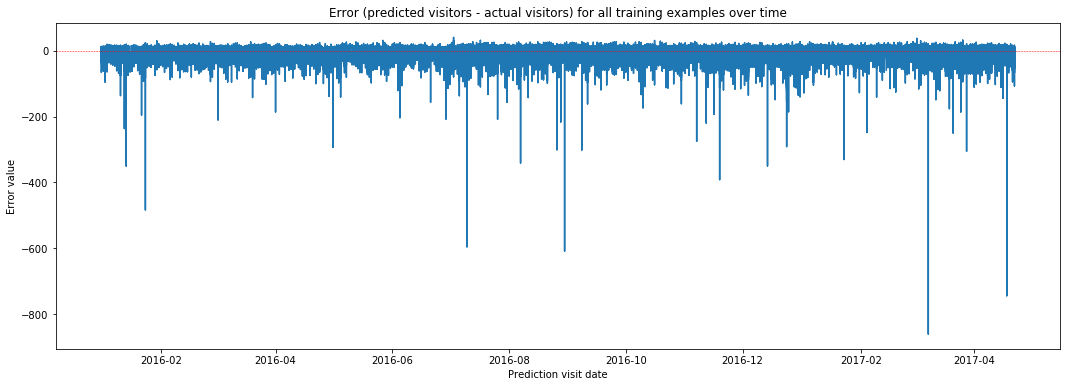

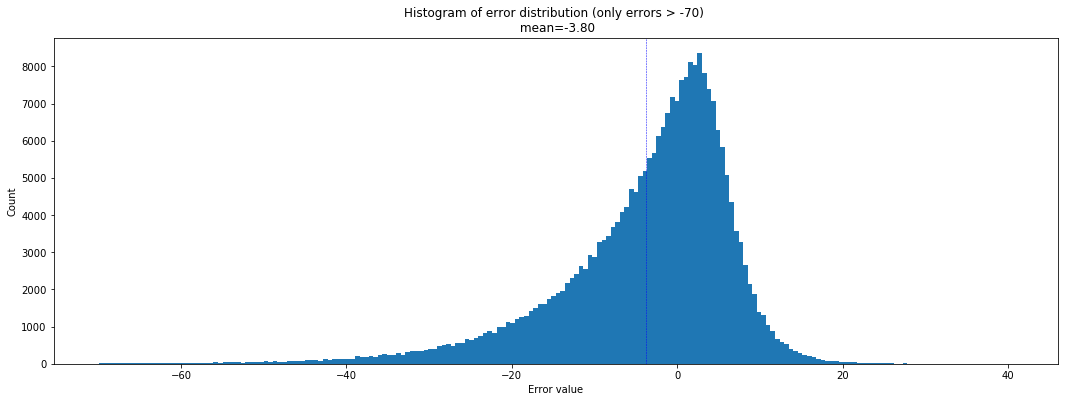


Model name:  KNeighborsRegressor
Details: 
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

RMSLE KNeighborsRegressor: 0.42


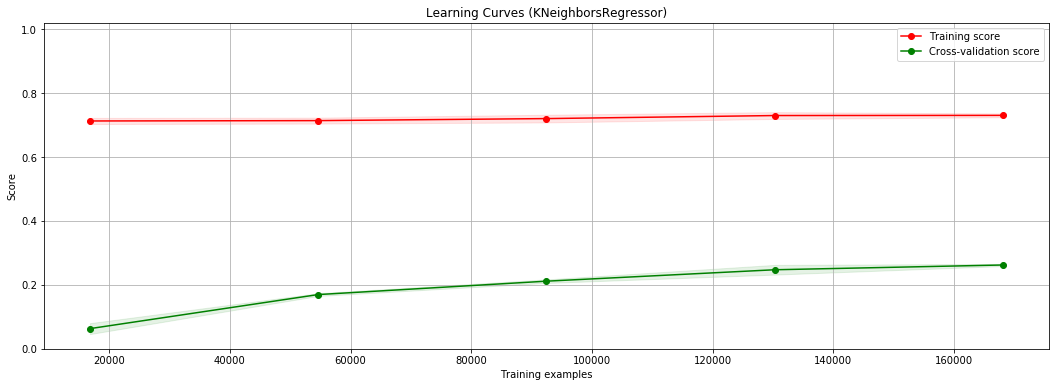

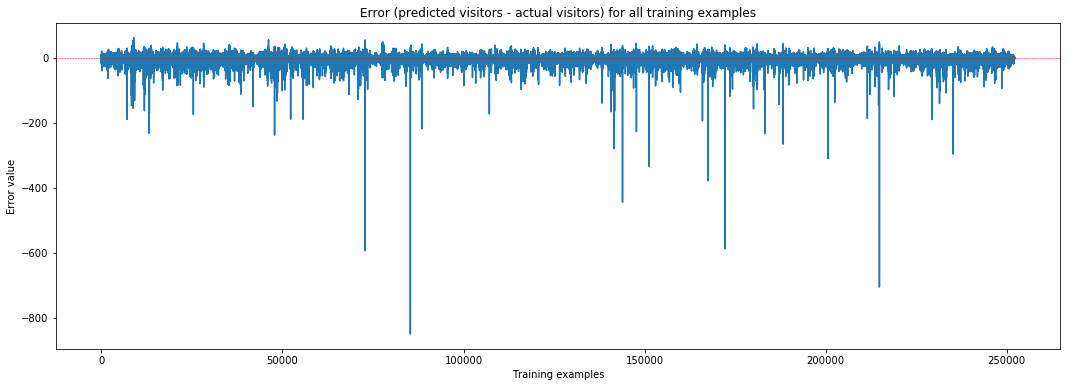

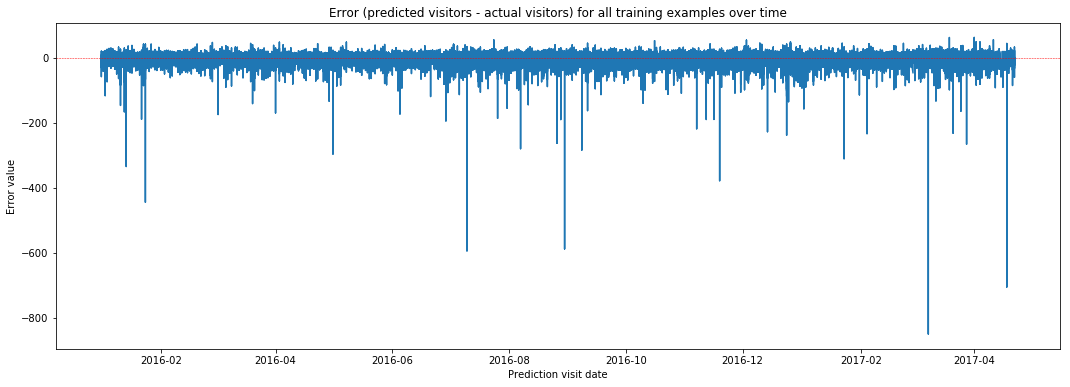

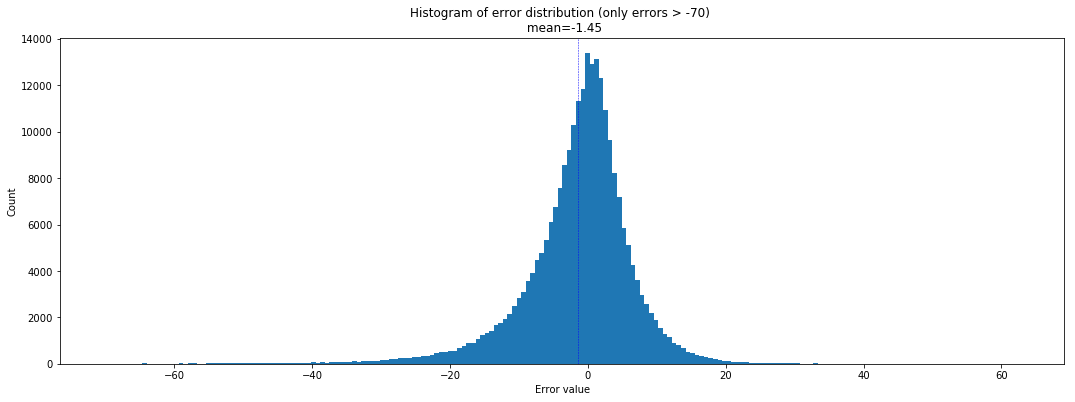


Model name:  XGBRegressor
Details: 
 XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=20, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3, silent=True, subsample=0.8)

RMSLE XGBRegressor: 0.46


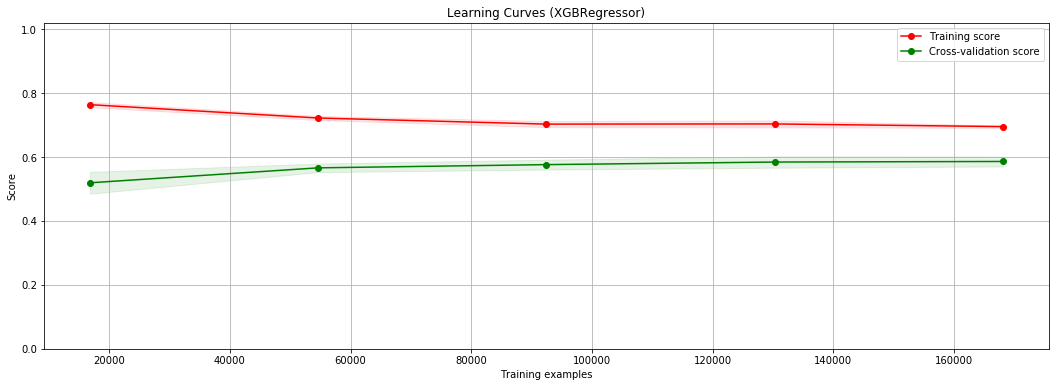

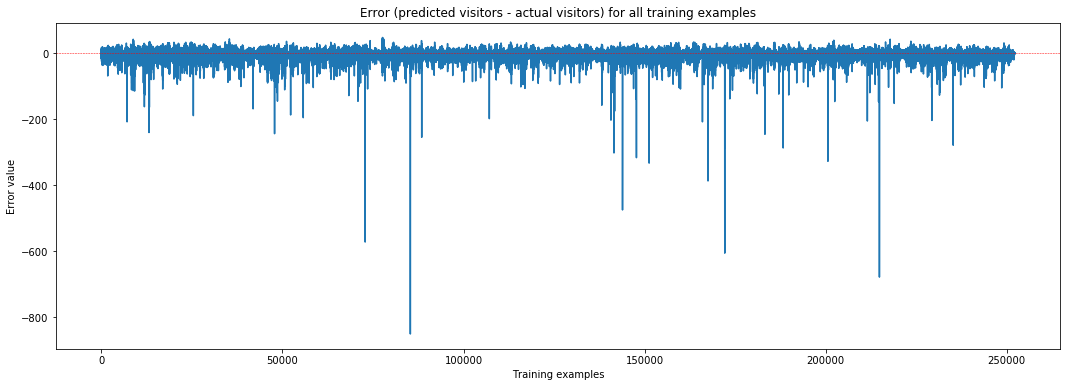

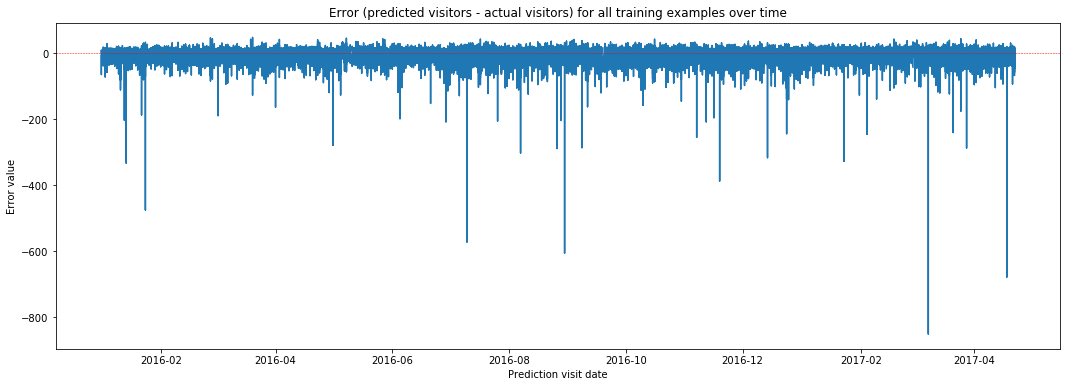

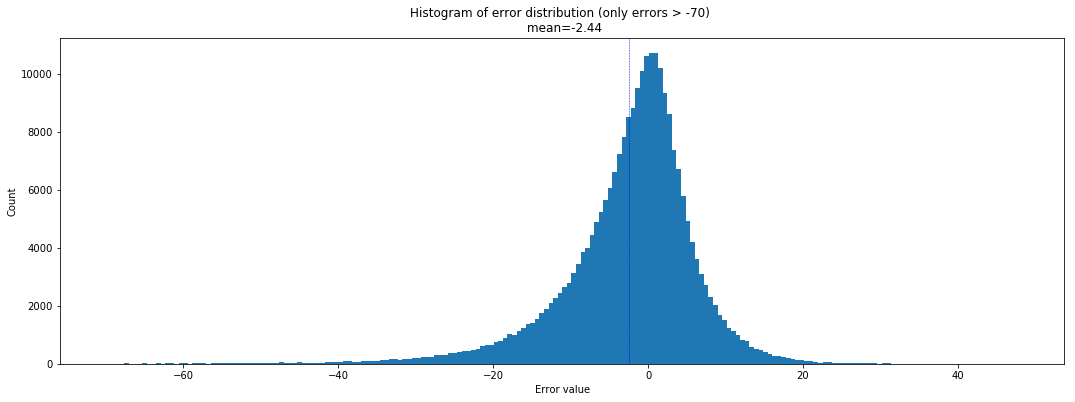

In [19]:
for name, model in models:
    print("\nModel name: ", name)
    print("Details: \n", model)
    
    y_pred, score = train_and_predict(model, X_train, y_train)
    print('\nRMSLE {0}: {1:0.2f}'.format(name, score))
    
    plot_learning_curve(model, "Learning Curves ({0})".format(name), 
                        X_train, y_train, ylim=(0.0, 1.02), cv=3, n_jobs=8)
    
    plot_error_evaluation_1(train, y_train, y_pred)
    plot_error_evaluation_2(train, y_train, y_pred)
    plot_error_evaluation_3(train, y_train, y_pred)

#### Model prediction on Test dataset

In [20]:
y_test_1 = model1.predict(X_test)
y_test_2 = model2.predict(X_test)
y_test_3 = model3.predict(X_test)

In [21]:
#test['visitors'] = 0.3*preds1+0.3*preds2+0.4*preds3
test['visitors'] = y_test_1
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()

# TODO: delete unneeded 
#del train; del data;

In [22]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../data/raw/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = 0.7*sub_merge['visitors_x'] + 0.3*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('../output/submission.csv', index=False)

In [23]:
print('done!')

done!
